In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Data Analysing

In [3]:
#Read your train dataset:
diamonds = pd.read_csv('../data/diamonds_train.csv')

#Read dataset you want to predict the price from:
diamonds_predict = pd.read_csv('../data/diamonds_test.csv')

In [4]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [4]:
diamonds.shape

(40455, 10)

In [5]:
#The training dataset has some duplicated, this will help the final result:
diamonds.drop_duplicates(inplace=True)

In [6]:
#Make sure there aren't null values on the training dataset:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
#Make sure there aren't null values on the test dataset:
diamonds_predict.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [8]:
#Take a look at your columns type to differenciate the numeric columns from the ones with strings:
diamonds.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [9]:
#Take a look to the descripts statistics of your training dataset:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,40366.000000,40366.000000,40366.000000,40366.000000,40366.000000,40366.000000,40366.000000
mean,0.797618,61.752175,57.447215,3929.292177,5.729613,5.733094,3.537269
std,0.475042,1.431303,2.233827,3991.910295,1.123422,1.145746,0.696417
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2398.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.030000
max,4.500000,79.000000,95.000000,18823.000000,10.230000,58.900000,8.060000


In [10]:
#Take a look at the correlation that the columns have with diamond's price:
diamonds.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.026276,0.182582,0.921939,0.976034,0.951921,0.967847
depth,0.026276,1.000000,-0.293036,-0.015158,-0.026179,-0.030807,0.094861
table,0.182582,-0.293036,1.000000,0.129415,0.195397,0.183989,0.154517
price,0.921939,-0.015158,0.129415,1.000000,0.886023,0.866246,0.874605
x,0.976034,-0.026179,0.195397,0.886023,1.000000,0.973612,0.984842
y,0.951921,-0.030807,0.183989,0.866246,0.973612,1.000000,0.964720
z,0.967847,0.094861,0.154517,0.874605,0.984842,0.964720,1.000000


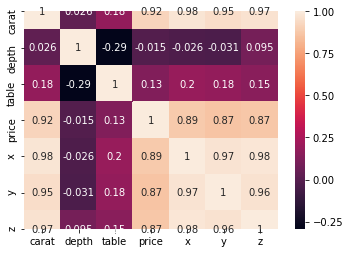

In [11]:
corr = diamonds.corr()
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

# Data Visualization

Text(0.5, 1.0, 'z vs price')

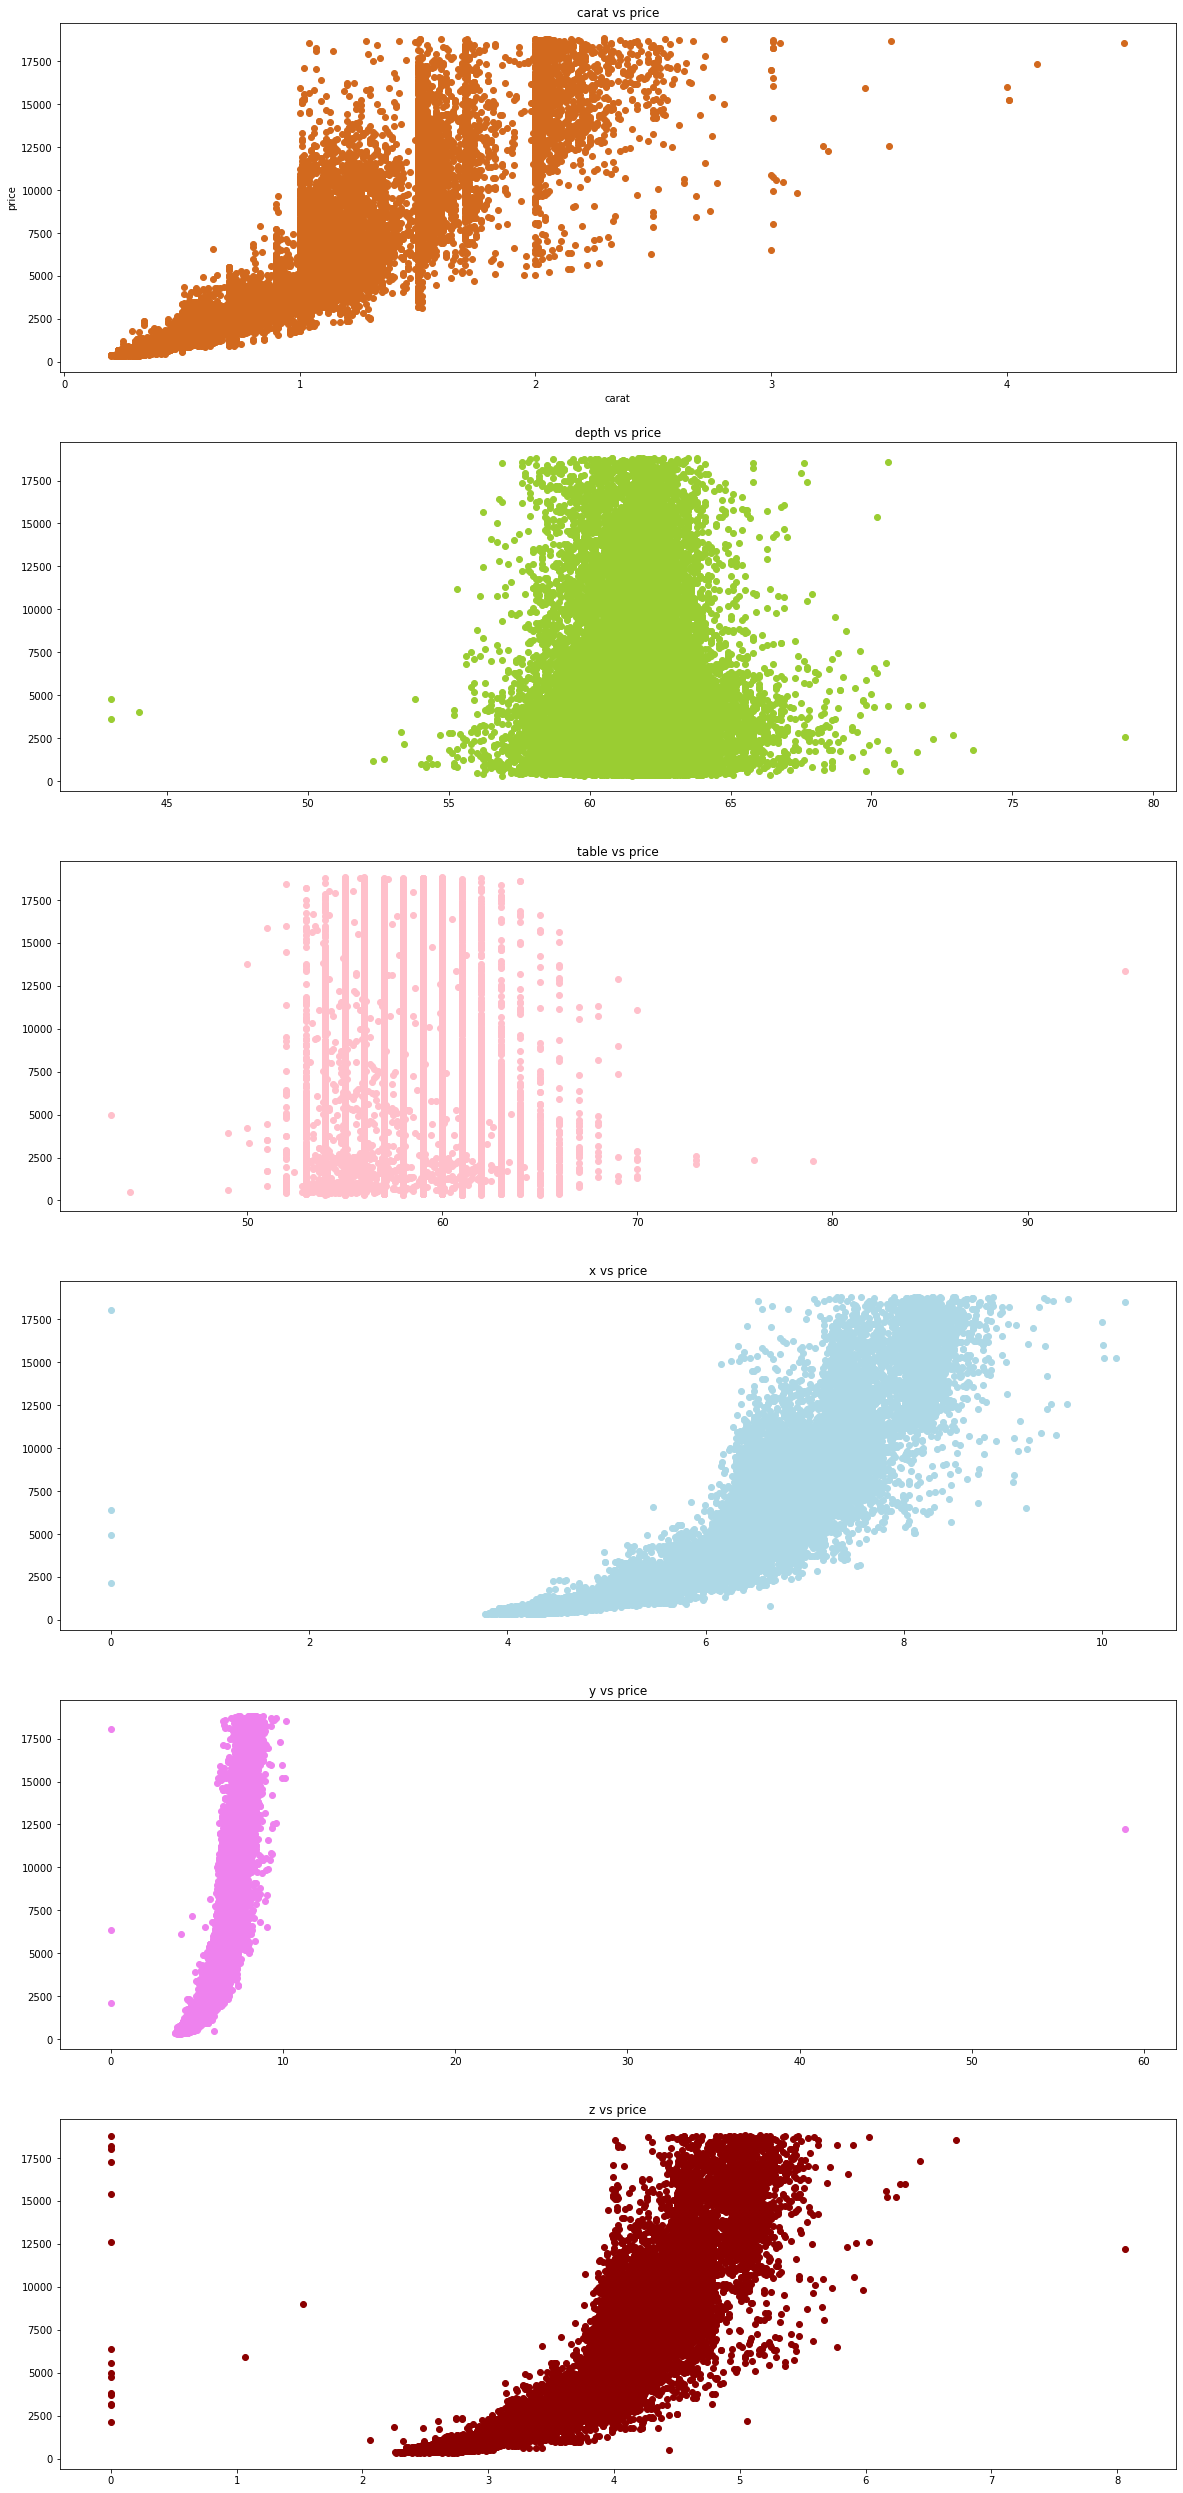

In [12]:
#Data visualization helps to see how the data from numeric columns changes with the price:
fig, axes = plt.subplots(nrows = 6, ncols =1, figsize=(20,45))
axes[0].scatter(diamonds['carat'], diamonds['price'] , color='chocolate')
axes[0].set_xlabel('carat')
axes[0].set_ylabel('price')
axes[0].set_title('carat vs price')
axes[1].scatter(diamonds['depth'], diamonds['price'], color='yellowgreen')
axes[1].set_title('depth vs price')
axes[2].scatter(diamonds['table'], diamonds['price'] , color='pink')
axes[2].set_title('table vs price')
axes[3].scatter(diamonds['x'], diamonds['price'], color='lightblue')
axes[3].set_title('x vs price')
axes[4].scatter(diamonds['y'], diamonds['price'], color='violet')
axes[4].set_title('y vs price')
axes[5].scatter(diamonds['z'], diamonds['price'], color='darkred')
axes[5].set_title('z vs price')

# Add new data and Data Cleaning

In [13]:
#Add a column which is the logarithm of carat. 
#This is because the values of carat increase exponential and not lineal with the price.
carat_log= []
for i in diamonds['carat']:
    carat_log.append(math.log(i))
diamonds['carat_log'] = carat_log

carat_log= []
for i in diamonds_predict['carat']:
    carat_log.append(math.log(i))
diamonds_predict['carat_log'] = carat_log

#### There are numeric columns with 0 values in it and that data doesn't make sense. Bellow you can see some examples

In [14]:
diamonds.loc[diamonds['x']==0]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_log
6465,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.00,0.0,-0.342490
14815,1.07,Ideal,F,SI2,61.6,56.0,4954,0.0,6.62,0.0,0.067659
26192,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.00,0.0,0.810930
34423,1.14,Fair,G,VS1,57.5,67.0,6381,0.0,0.00,0.0,0.131028


In [15]:
diamonds_predict.loc[diamonds_predict['x']==0]

,id,carat,cut,color,clarity,depth,table,x,y,z,carat_log
2901,2901,1.20,Premium,D,VVS1,62.1,59.0,0.0,0.0,0.0,0.182322
6685,6685,1.00,Very Good,H,VS2,63.3,53.0,0.0,0.0,0.0,0.000000
7488,7488,1.56,Ideal,G,VS2,62.2,54.0,0.0,0.0,0.0,0.444686


In [16]:
diamonds.loc[diamonds['y']==0]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_log
6465,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.0,0.0,-0.342490
26192,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0,0.810930
34423,1.14,Fair,G,VS1,57.5,67.0,6381,0.0,0.0,0.0,0.131028


In [17]:
diamonds_predict.loc[diamonds_predict['y']==0]

,id,carat,cut,color,clarity,depth,table,x,y,z,carat_log
2901,2901,1.20,Premium,D,VVS1,62.1,59.0,0.0,0.0,0.0,0.182322
6685,6685,1.00,Very Good,H,VS2,63.3,53.0,0.0,0.0,0.0,0.000000
7488,7488,1.56,Ideal,G,VS2,62.2,54.0,0.0,0.0,0.0,0.444686


#### Since it's not possible to remove values from the dataset you want to predict the price, it's important to turn the zero values into data that makes more sense, that's why I created the following function:

In [18]:
def remove_column_zero(col):
    for i in diamonds_predict[col].index:
        if diamonds_predict[col][i]==0:
            diamonds_predict[col][i] = diamonds_predict[col].median()
remove_column_zero('x')
remove_column_zero('y')
remove_column_zero('z')

/home/almsasantos/miniconda3/envs/data_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
#On your training data you can simply remove them:
diamonds = diamonds.loc[(diamonds['x']>0) | (diamonds['y']>0) | (diamonds['z']>0)]

In [20]:
#Doesn't make sense to have diamonds with width and depth higher than 20:
diamonds = diamonds.loc[~((diamonds['y'] > 20) | (diamonds['z'] > 20))]

#### It's important to know that the diamond's price is highly dependent from the ratio length/width.

In [21]:
diamonds['ratio_length_width'] = diamonds['x']/diamonds['y']
diamonds_predict['ratio_length_width'] = diamonds_predict['x']/diamonds_predict['y']

#### You could also think that columns as ratio_lenth_width_depth, volume, density would give you crutial information to predict prices. But the following columns will actually give you a bigger root mean square error. That's why when we'll train the model, you'll remove those columns.

In [22]:
diamonds['ratio_length_width_depth'] = diamonds['x']/diamonds['y']/diamonds['z']
diamonds_predict['ratio_length_width_depth'] = diamonds_predict['x']/diamonds_predict['y']/diamonds_predict['z']

diamonds['volume'] = diamonds['x']*diamonds['y']*diamonds['z']
diamonds_predict['volume'] = diamonds_predict['x']*diamonds_predict['y']*diamonds_predict['z']

diamonds['density'] = diamonds['carat']/diamonds['volume']
diamonds_predict['density'] = diamonds_predict['carat']/diamonds_predict['volume']

### One of the most important things when we talk about diamond's price is their Shape. Just to give you some notation, Round Shape diamonds are the most wanted, that's why they're the most expensive ones.

#### There are a lot more diamonds shape, but since some of them have the same range of depth and table, I found it impossible to divide in more than 4 shapes.

In [23]:
shape = []
for i in diamonds['table'].index:
    if 54<diamonds['table'][i]<57 and 61<diamonds['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds['table'][i]<60 and 60<diamonds['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds['table'][i]<69 and 69<diamonds['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds['table'][i]<63 and 58<diamonds['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [24]:
diamonds['shape'] = shape

In [25]:
#Do the same for the dataset you want to predict the price from:
shape = []
for i in diamonds_predict['table'].index:
    if 54<diamonds_predict['table'][i]<57 and 61<diamonds_predict['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_predict['table'][i]<60 and 60<diamonds_predict['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_predict['table'][i]<69 and 69<diamonds_predict['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_predict['table'][i]<63 and 58<diamonds_predict['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [26]:
diamonds_predict['shape'] = shape

In [27]:
diamonds['shape'].value_counts()

Oval        23671
Round        7793
Cushion      6322
others       2575
Princess        1
Name: shape, dtype: int64

# Transform your data

In [28]:
diamonds['cut']=diamonds['cut'].map({'Fair':0,'Good':1,'Very Good':2,'Premium':3, 'Ideal':4})
diamonds['color']=diamonds['color'].map({'J':0, 'I':1, 'H':2, 'G':3, 'F': 4, 'E': 5, 'D':6})
diamonds['clarity']=diamonds['clarity'].map({'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7})

#For this column I had to search the price of the shapes. From 4 (most expensive) to 0 (less expensive):
diamonds['shape']=diamonds['shape'].map({'Round':4, 'Oval': 1, 'Princess': 3, 'Cushion':2, 'others':0})

In [29]:
diamonds_predict['cut']=diamonds_predict['cut'].map({'Fair':0,'Good':1,'Very Good':2,'Premium':3, 'Ideal':4})
diamonds_predict['color']=diamonds_predict['color'].map({'J':0, 'I':1, 'H':2, 'G':3, 'F': 4, 'E': 5, 'D':6})
diamonds_predict['clarity']=diamonds_predict['clarity'].map({'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7})

#For this column I had to search the price of the shapes. From 4 (most expensive) to 0 (less expensive):
diamonds_predict['shape']=diamonds_predict['shape'].map({'Round':4, 'Oval': 1, 'Princess': 3, 'Cushion':2, 'others':0})

# Training your Supervised Model

In [30]:
# I tried other data transformation such as MinMaxScaler and RobustScaler, but StandardScaler was the one which gave better results:
scaler = StandardScaler()

In [32]:
X = scaler.fit_transform(diamonds.drop(['price', 'depth', 'table', 'x', 'y', 'z', 'volume', 'density', 'ratio_length_width_depth', 'carat'], axis=1))
y = diamonds['price'].values

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_test, label=y_test)

In [35]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':1,
    'verbose':10,
    'early_stopping_round': 20
}

In [36]:
n_estimators = 115
watchlist=[d_valid]

In [37]:
model = lgb.LGBMRegressor()

In [ ]:
scores = cross_val_score(model, 
                         X, 
                         y, 
                         scoring='neg_root_mean_squared_error',
                        cv=10)

In [ ]:
#Define the parameters you want to test to see which one has better results:
param_grid = {
    'n_estimators':[114, 115, 116], 
    'max_depth:':['auto', 1],
    'num_leaves': [31, 40, 60],
    'learning_rate': [0.005, 0.1],
    'bagging_fraction': [0.70, 0.75],
    'max_bin': [128, 256],
    'feature_fraction' : [0.75, 0.8],
    'bagging_frequency' : [0.70, 0.80],
    'min_data_in_leaf': [15, 20, 25]
}

In [ ]:
#GridSearchCV will give you the best model based on the parameters you passed:
grid_search = GridSearchCV(model, 
                           param_grid=param_grid,
                           cv=10, 
                           verbose=10, 
                           scoring='neg_root_mean_squared_error',
                          n_jobs=-1) #n_iter=100

In [ ]:
grid_search.fit(X, y)

In [ ]:
grid_search.best_estimator_

In [ ]:
gbm = lgb.train(params,
                d_train,
                n_estimators,
                watchlist,
                verbose_eval=1)

In [ ]:
X_test = scaler.transform(diamonds_predict.drop(['id', 'depth', 'table', 'x', 'y', 'z', 'volume', 'density', 'ratio_length_width_depth', 'carat'], axis=1).values)

In [ ]:
preds = grid_search.predict(X_test)

In [ ]:
output = pd.DataFrame({'id': diamonds_predict['id'], 'price': preds})
output.to_csv("submission.csv", index=False)

In [ ]:
output

In [ ]:
output.describe()